*As always, you should begin by choosing the menu options `File -> Save a copy in Drive` for a copy you can work with.*

# Data Wrangling Day 17 March 3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Geospatial data adds "where" to data

Geospatial data, at its core, is information that connects data points to specific locations on Earth. It's not just about having coordinates; it's about understanding the spatial relationships between different pieces of information. Think of it as enriching your datasets with a crucial dimension: location. This "where" component allows us to analyze patterns, trends, and connections that are impossible to discern with traditional, non-spatial data.

**Why is Geospatial Data Important?**

Geospatial data is vital because it:

* **Provides Context:** It allows us to understand how phenomena are distributed across space. For example, knowing the location of customer purchases helps businesses understand market trends and optimize store placement.
* **Enables Spatial Analysis:** It allows us to perform complex analyses, such as identifying clusters of disease outbreaks, predicting flood risk, or optimizing delivery routes.
* **Supports Informed Decision-Making:** From urban planning to environmental management, geospatial data provides critical insights for making informed decisions.
* **Drives Innovation:** It fuels innovation in various fields, including navigation, agriculture, and disaster response.

**Common Geospatial Data Types for Analysis:**

When wrangling geospatial data, you'll encounter several common data types, each with its own structure and purpose:

* **Vector Data:**
    * This represents geographic features as discrete objects.
    * **Points:** Represent single locations (e.g., the location of a store, a tree).
    * **Lines:** Represent linear features (e.g., roads, rivers, pipelines).
    * **Polygons:** Represent areas (e.g., countries, parks, buildings).
    * Vector data is ideal for representing discrete features with clear boundaries.
* **Raster Data:**
    * This represents geographic features as a grid of cells or pixels.
    * Each cell contains a value representing a specific attribute (e.g., elevation, temperature, land cover).
    * Raster data is well-suited for representing continuous phenomena and imagery (e.g., satellite images, digital elevation models).
* **Geographic Coordinates:**
    * Latitude and longitude coordinates are the most common way to define a location.
    * These coordinates are essential for geocoding and georeferencing data.
* **Geographic Information Systems (GIS) Data:**
    * This is not a data type in itself, but rather a system that organizes, analyzes, and displays geospatial data.
    * GIS data can be stored in various formats, including shapefiles, GeoJSON, and geodatabases.
    * GeoJSON is becoming a very popular format for web based applications.


## Vector representations of data

We'll use the `shapely.geometry` library in Python to define vector data geometries and operations.  We'll use the `geopandas` library to create `GeoDataFrames`, which are like `pandas` data frames but have a designated column holding a map geometry.  Let's import the packages we need for this example.

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

Let's create a few data points "by hand".  We'll read in files later.  Notice that just like with `pandas`, we can store the data in a dictionary.

In [ ]:
data = {
    'park_name': ['Central Park', 'Riverside Park', 'Greenwood Park', 'Sunset Park', 'Hillside Park'],
    'latitude': [40.785091, 40.801579, 40.662589, 40.645781, 40.709328],
    'longitude': [-73.968285, -73.974441, -73.987019, -74.001646, -73.931165]
}

Convert to a `GeoDataFrame`.  We'll have to do this in two steps, first creating the `Point` geometry objects, and then the `GeoDataFrame`.  Notice that when we create the `GeoDataFrame`, we explicitly state the `geometry` column.  It does not have to be named `geometry` before beign added to the `GeoDataFrame`.

In [ ]:
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
gdf_parks = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

Visualize?

Text(209.73887188989391, 0.5, 'Latitude')

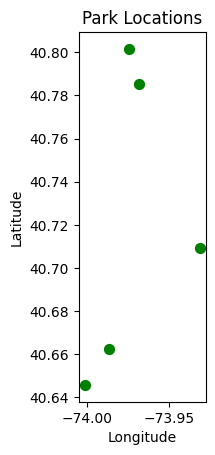

In [ ]:
gdf_parks.plot(marker='o', color='green', markersize=50)
plt.title("Park Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Just as an example of what we can do with points, let's add a buffer to each point of a few hundred meters.  This will help us visualize which parks are close in a more precise sense.  When we look at the data, we can see that our original geometry column has point type all the way down, while our new buffer column is a polygon all the way down.

In [ ]:
gdf_parks['buffer'] = gdf_parks.geometry.buffer(500)
gdf_parks.head()

<ipython-input-6-4f78beb368e5>:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_parks['buffer'] = gdf_parks.geometry.buffer(500)


park_name   latitude  longitude                    geometry  \
0    Central Park  40.785091 -73.968285  POINT (-73.96828 40.78509)   
1  Riverside Park  40.801579 -73.974441  POINT (-73.97444 40.80158)   
2  Greenwood Park  40.662589 -73.987019  POINT (-73.98702 40.66259)   
3     Sunset Park  40.645781 -74.001646  POINT (-74.00165 40.64578)   
4   Hillside Park  40.709328 -73.931165  POINT (-73.93116 40.70933)   

                                              buffer  
0  POLYGON ((426.03172 40.78509, 423.62408 -8.223...  
1  POLYGON ((426.02556 40.80158, 423.61792 -8.206...  
2  POLYGON ((426.01298 40.66259, 423.60534 -8.345...  
3  POLYGON ((425.99835 40.64578, 423.59072 -8.362...  
4  POLYGON ((426.06884 40.70933, 423.6612 -8.2992...

Let's plot the buffers.

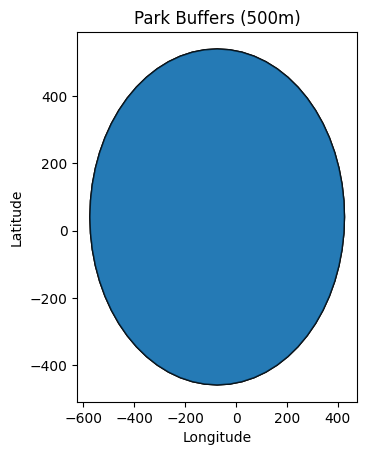

In [ ]:
gdf_parks.set_geometry('buffer').plot(alpha=0.5, edgecolor='k')
plt.title("Park Buffers (500m)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Yikes, what went wrong?  Well, we are working in the wrong coordinate system.  Let's change it first, then buffer, then plot.  What coordinate system are we in now?

In [ ]:
gdf_parks.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The WGS and EPSG coordinates are in degrees, not meters.  Let's change.  We're at around 40 degrees north.  This is [very searchable](https://epsg.io/32640).

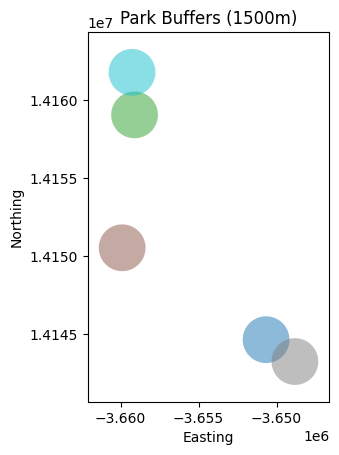

In [ ]:
gdf_parks_projected = gdf_parks.to_crs(epsg=32640)
gdf_parks_projected['buffer'] = gdf_parks_projected.geometry.buffer(1500)
gdf_parks_projected.set_geometry('buffer').plot(column='park_name', alpha=0.5)
plt.title("Park Buffers (1500m)")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()

## Computations

We can make some basic computations with our data.  Let's grab the first row of data.

In [ ]:
first_park = gdf_parks_projected.iloc[0]
first_park

park_name                                         Central Park
latitude                                             40.785091
longitude                                           -73.968285
geometry         POINT (-3650668.323046795 14144628.738199351)
buffer       POLYGON ((-3649168.323046795 14144628.73819935...
Name: 0, dtype: object

Let's compute distances.  We need to use the `shapely` geometry objects when computing, so we call on the `geometry` attributes.

In [ ]:
first_park.geometry.distance(gdf_parks_projected.geometry)

0        0.000000
1     2319.261493
2    16696.498690
3    19170.794120
4    10946.328848
Name: geometry, dtype: float64

You could find the distances from the selected park to all of the buffers instead.

In [ ]:
first_park.geometry.distance(gdf_parks_projected['buffer'])

0        0.000000
1      820.945721
2    15197.714432
3    17671.352683
4     9446.702976
Name: buffer, dtype: float64

## A larger example

In [ ]:
districts = gpd.read_file("https://github.com/cbrown-clu/class_data/raw/refs/heads/main/data/Paris/paris_districts_utm.geojson")

In [ ]:
type(districts)

geopandas.geodataframe.GeoDataFrame

In [ ]:
districts.head()

id           district_name  population  \
0   1  St-Germain-l'Auxerrois        1672   
1   2                  Halles        8984   
2   3            Palais-Royal        3195   
3   4           Place-Vendôme        3044   
4   5                 Gaillon        1345   

                                            geometry  
0  POLYGON ((451922.133 5411438.484, 451922.08 54...  
1  POLYGON ((452278.419 5412160.893, 452192.407 5...  
2  POLYGON ((451553.806 5412340.522, 451528.058 5...  
3  POLYGON ((451004.908 5412654.095, 450960.64 54...  
4  POLYGON ((451328.752 5412991.278, 451294.721 5...

<Axes: >

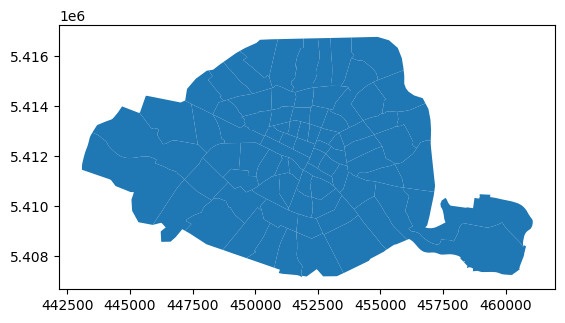

In [ ]:
districts.plot()

<Axes: >

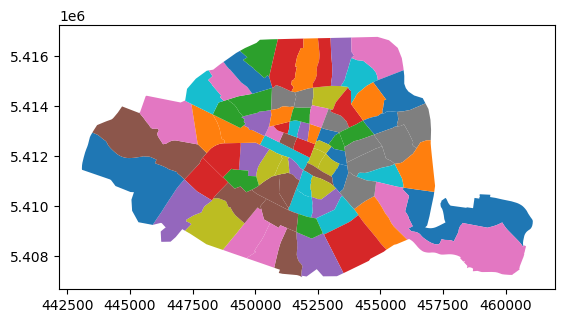

In [ ]:
districts.plot(column='district_name')

<Axes: >

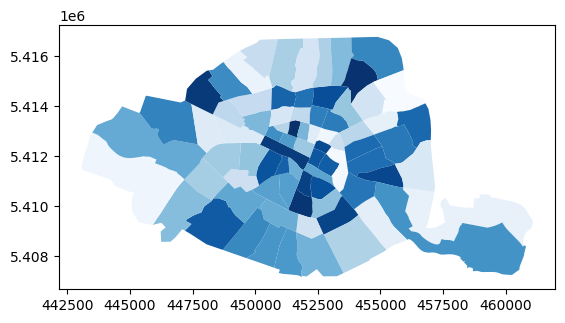

In [ ]:
districts.plot(column='district_name',cmap='Blues')

In [ ]:
stations = gpd.read_file("https://github.com/cbrown-clu/class_data/raw/refs/heads/main/data/Paris/paris_sharing_bike_stations_utm.geojson")
stations.head()

name  bike_stands  available_bikes  \
0               14002 - RASPAIL QUINET           44                4   
1  20503 - COURS DE VINCENNES PYRÉNÉES           21                3   
2             20011 - PYRÉNÉES-DAGORNO           21                0   
3        31008 - VINCENNES (MONTREUIL)           56                0   
4          43006 - MINIMES (VINCENNES)           28               27   

                         geometry  
0  POINT (450804.449 5409797.268)  
1  POINT (456414.352 5410698.461)  
2   POINT (456366.909 5411563.32)  
3  POINT (458730.707 5411789.995)  
4   POINT (458234.93 5409991.067)

<Axes: >

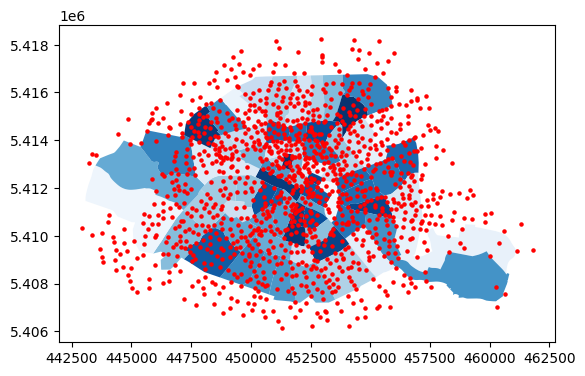

In [ ]:
ax = districts.plot(column='district_name',cmap='Blues')
stations.plot(ax=ax, marker='o', color='red', markersize=5)

In [ ]:
districts = districts.to_crs(epsg=32640)
stations = stations.to_crs(epsg=32640)

<Axes: >

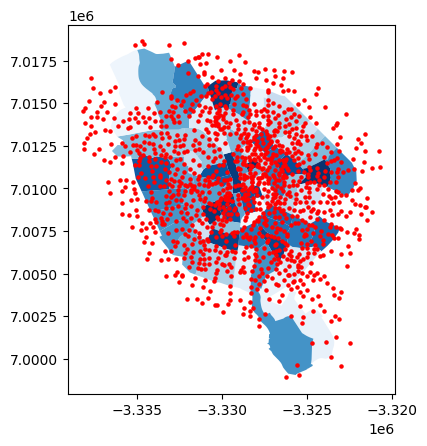

In [ ]:
ax = districts.plot(column='district_name',cmap='Blues')
stations.plot(ax=ax, marker='o', color='red', markersize=5)

In [ ]:
stations_in_paris = stations[stations.within(districts.geometry.union_all())]

In [ ]:
stations_in_paris.head()

name  bike_stands  available_bikes  \
0                       14002 - RASPAIL QUINET           44                4   
1          20503 - COURS DE VINCENNES PYRÉNÉES           21                3   
2                     20011 - PYRÉNÉES-DAGORNO           21                0   
7                       01007 - ETIENNE MARCEL           16               14   
9  20019 - MAQUIS DU VERCORS - PORTE DES LILAS           30                1   

                           geometry  
0   POINT (-3331687.918 7009293.79)  
1  POINT (-3326318.956 7005230.455)  
2  POINT (-3325617.828 7005979.767)  
7  POINT (-3328268.397 7010343.956)  
9  POINT (-3323322.706 7007736.865)

<Axes: >

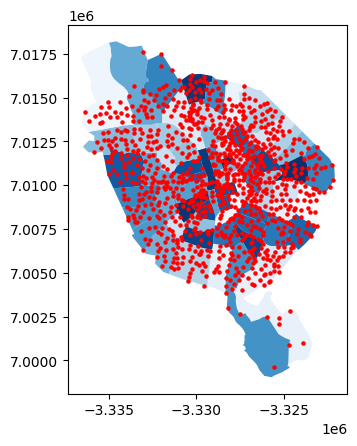

In [ ]:
ax = districts.plot(column='district_name',cmap='Blues')
stations_in_paris.plot(ax=ax, marker='o', color='red', markersize=5)

In [ ]:
trees = gpd.read_file("https://github.com/cbrown-clu/class_data/raw/refs/heads/main/data/Paris/paris_trees_small.gpkg")

In [ ]:
trees.head()

species location_type                        geometry
0  Marronnier    Alignement  POINT (455834.122 5410780.606)
1  Marronnier    Alignement  POINT (446546.284 5412574.697)
2  Marronnier    Alignement  POINT (449768.283 5409876.557)
3  Marronnier    Alignement  POINT (451779.708 5409292.071)
4     Sophora    Alignement  POINT (447041.361 5409756.712)

In [ ]:
trees = trees.to_crs(epsg=32640)

<Axes: >

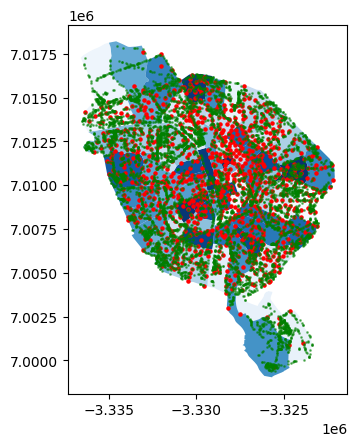

In [ ]:
ax = districts.plot(column='district_name',cmap='Blues')
stations_in_paris.plot(ax=ax, marker='o', color='red', markersize=5)
trees.plot(ax=ax, marker='o', color='green', markersize=1,alpha=0.5)

In [ ]:
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 48.7 MB/s eta 0:00:00


In [ ]:
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'
bakeries = gpd.read_file('https://github.com/cbrown-clu/class_data/raw/refs/heads/main/data/Paris/Paris%20Bakeries.kml', driver='KML')

In [ ]:
bakeries = bakeries.to_crs(epsg=32640)
bakeries

Name Description  \
0                        Notre Pâtisserie               
1                                  Odette               
2               Boulangerie La Parisienne               
3                 Gem la Pâtisserie Paris               
4        Les Gourmandises de Saint Honoré               
5                        Haute Pâtisserie               
6                     The French Bastards               
7      Le Moulin de Rosa - Laurent Watrin               
8                  Le Moulin de la Vierge               
9                            Maison Lucie               
10              Boulangerie La Parisienne               
11                 Petite Île Boulangerie               
12   Boulangerie Pâtisserie Miche de Pain               
13                       La tordue bakery               
14  Boulangerie du Parc Neuilly Sur Seine               
15      La Griotte Boulangerie Patisserie               
16                   Boulangerie, Artisan               
17                 Boulangerie-Pâtisserie               
18                                 Mozart               
19                            Boulangerie               
20                     Baker and Pastries               
21                             The Bakery               
22                  Boucherie Baker ADRAR               
23                           Clove Bakery               
24                         Adria's bakery               
25                                    Lam               
26                                   Gast               
27                   Atelier Guinot Baker               
28                              Sweet Lab               
29                            Sarah Baker               

                                geometry  
0   POINT Z (-3331081.825 7012487.426 0)  
1   POINT Z (-3329443.511 7009379.156 0)  
2   POINT Z (-3330700.614 7009983.636 0)  
3   POINT Z (-3328223.892 7011635.771 0)  
4   POINT Z (-3328822.083 7010541.132 0)  
5   POINT Z (-3327112.995 7007683.799 0)  
6   POINT Z (-3330469.729 7015412.357 0)  
7   POINT Z (-3327879.579 7008693.854 0)  
8   POINT Z (-3330953.479 7012487.063 0)  
9    POINT Z (-3329893.824 7013897.95 0)  
10  POINT Z (-3330711.502 7009988.484 0)  
11  POINT Z (-3327325.717 7009102.682 0)  
12  POINT Z (-3327224.904 7011714.502 0)  
13   POINT Z (-3325156.187 7007094.57 0)  
14  POINT Z (-3330574.491 7016553.502 0)  
15  POINT Z (-3330220.894 7015867.748 0)  
16  POINT Z (-3326051.509 7008547.619 0)  
17  POINT Z (-3325857.624 7009296.738 0)  
18  POINT Z (-3334897.475 7012290.754 0)  
19   POINT Z (-3320052.521 7004244.14 0)  
20   POINT Z (-3324476.711 7010880.92 0)  
21  POINT Z (-3319918.717 7015495.781 0)  
22  POINT Z (-3330160.721 7024521.954 0)  
23   POINT Z (-3328096.968 7010539.18 0)  
24   POINT Z (-3327572.899 7005919.17 0)  
25  POINT Z (-3327176.099 7009902.105 0)  
26  POINT Z (-3328883.579 7010091.671 0)  
27  POINT Z (-3326632.621 7008328.466 0)  
28   POINT Z (-3330980.084 7019692.49 0)  
29  POINT Z (-3340442.146 7007021.846 0)

<Axes: >

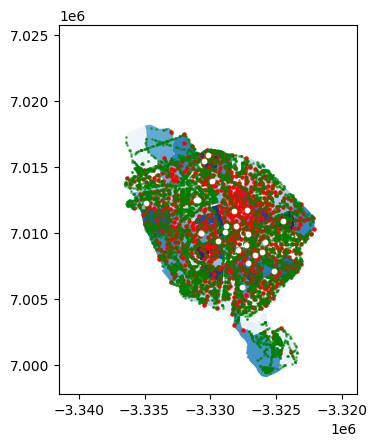

In [ ]:
ax = districts.plot(column='district_name',cmap='Blues')
stations_in_paris.plot(ax=ax, marker='o', color='red', markersize=5)
trees.plot(ax=ax, marker='o', color='green', markersize=1,alpha=0.5)
bakeries.plot(ax=ax, marker='o', color='white', markersize=10)

## Ventura County

You can find the Ventura County GIS Data Service at https://venturacountydatadownloads-vcitsgis.hub.arcgis.com/ .

You can find wildlife sightings records at https://www.inaturalist.org/ .

Here are some resources I stored in my github, so that you could get started with mapmaking in Ventura County.



In [ ]:
mask = gpd.read_file('https://github.com/cbrown-clu/class_data/raw/refs/heads/main/data/Ventura%20county%20data/Ventura_County_-_Mask.geojson').to_crs(epsg=26910)
mask.head()

objectid                county  county_typ  county_no     perimeter  \
0         1         Pacific Ocean           0          0  1.047312e+06   
1         2  Santa Barbara County           2          4  5.551119e+05   
2         3        Ventura County           1          1  1.000961e+06   
3         4          Kern County            2          3  8.189441e+05   
4         5    Los Angeles County           2          2  1.031042e+06   

          acres created_user created_date last_edited_user last_edited_date  \
0  7.379422e+05         None         None             None             None   
1  3.362779e+05         None         None             None             None   
2  1.172745e+06         None         None             None             None   
3  5.053456e+05         None         None             None             None   
4  7.359354e+05         None         None             None             None   

                                 globalid  shape_Length  shape_Area  \
0  {C0F8979C-5E70-4B95-9DC1-E2D5BDE5AA39}      3.273631    0.293154   
1  {4D53EDD1-E7FB-4751-9FCE-6E92E1BCA129}      1.621735    0.133839   
2  {CB6E0099-0135-4FC3-9D7E-E92C6D7ED564}      3.000956    0.465742   
3  {ACF49F10-E6C3-4549-9E23-21C00E9C405C}      2.636023    0.201451   
4  {A108922E-06D4-4C51-B2ED-6711046B0CBA}      3.065246    0.292098   

                                            geometry  
0  MULTIPOLYGON (((809314.259 3813451.432, 809406...  
1  MULTIPOLYGON (((824893.108 3867856.341, 824946...  
2  MULTIPOLYGON (((824893.108 3867856.341, 825709...  
3  MULTIPOLYGON (((820247.283 3879834.003, 850203...  
4  MULTIPOLYGON (((876207.32 3859103.597, 875556....

In [ ]:
mask = mask[mask['county'] == 'Ventura County']

<Axes: >

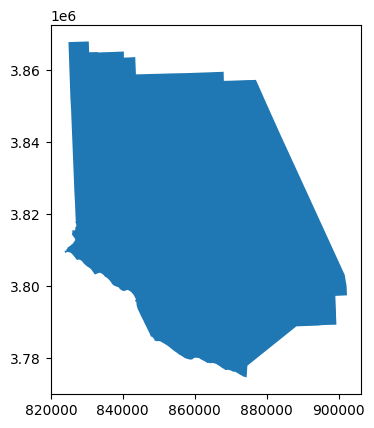

In [ ]:
mask.plot()

In [ ]:
mask.area

2    4.757974e+09
dtype: float64

In [ ]:
rivers_streams = (
    gpd.read_file('https://github.com/cbrown-clu/class_data/raw/refs/heads/main/data/Ventura%20county%20data/RiverStreams.geojson')
    .to_crs(epsg=26910)
    .clip(mask)
)

<Axes: >

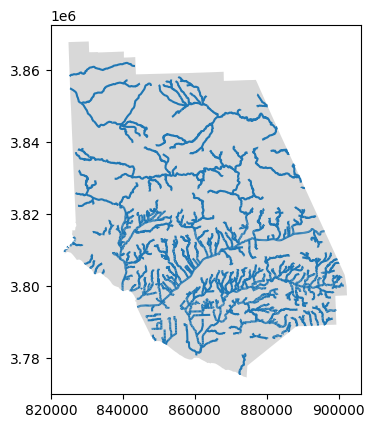

In [ ]:
ax = mask.plot(alpha=0.3,color='gray')
rivers_streams.plot(ax=ax)

In [ ]:
greenbelts = (
    gpd.read_file('https://github.com/cbrown-clu/class_data/raw/refs/heads/main/data/Ventura%20county%20data/Greenbelts.geojson')
    .to_crs(epsg=26910)
    .clip(mask)
)

<Axes: >

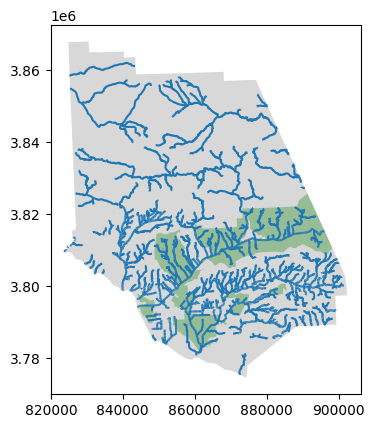

In [ ]:
ax = mask.plot(alpha=0.3,color='gray')
rivers_streams.plot(ax=ax)
greenbelts.plot(ax=ax,color='green',alpha=0.3)

In [ ]:
bobcats = pd.read_csv('https://github.com/cbrown-clu/class_data/raw/refs/heads/main/data/Ventura%20county%20data/inaturalist%20bobcats%20ventura%20county.csv')

In [ ]:
bobcats.head()

id   latitude   longitude scientific_name common_name
0   33472  34.289878 -118.821688      Lynx rufus      Bobcat
1  123818  34.117729 -119.078895      Lynx rufus      Bobcat
2  338504  34.688036 -119.358856      Lynx rufus      Bobcat
3  584954  34.156667 -118.963167      Lynx rufus      Bobcat
4  585550  34.023262 -118.956575      Lynx rufus      Bobcat

In [ ]:
bobcats['geometry'] = bobcats.apply(lambda x: Point((x.longitude, x.latitude)), axis=1)
bobcats = (
    gpd.GeoDataFrame(bobcats, geometry='geometry',crs='epsg:4326')
    .to_crs(epsg=26910)
    .clip(mask)
)
bobcats.head()

id   latitude   longitude scientific_name common_name  \
267  144859912  34.070166 -118.959000      Lynx rufus      Bobcat   
7      1097005  34.073511 -119.009067      Lynx rufus      Bobcat   
102   34450293  34.074047 -119.015774      Lynx rufus      Bobcat   
232  106869443  34.076472 -119.014733      Lynx rufus      Bobcat   
199   95781341  34.132589 -118.907680      Lynx rufus      Bobcat   

                           geometry  
267   POINT (872986.41 3777311.691)  
7     POINT (868347.908 3777501.06)  
102  POINT (867726.138 3777536.371)  
232   POINT (867811.783 3777809.25)  
199  POINT (877448.369 3784428.541)

<Axes: >

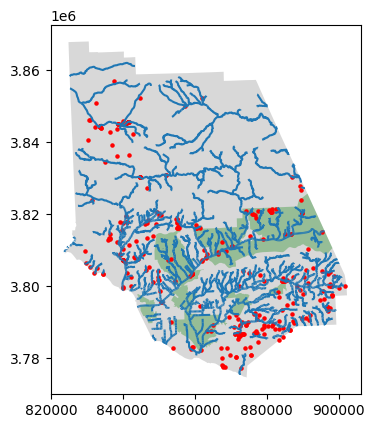

In [ ]:
ax = mask.plot(alpha=0.3,color='gray')
rivers_streams.plot(ax=ax)
greenbelts.plot(ax=ax,color='green',alpha=0.3)
bobcats.plot(ax=ax,marker='o',color='red',markersize=5)

In [ ]:
rivers_streams['buffer'] = rivers_streams.buffer(200)
bobcats_near_water = bobcats[bobcats.within(rivers_streams['buffer'].union_all())]

<Axes: >

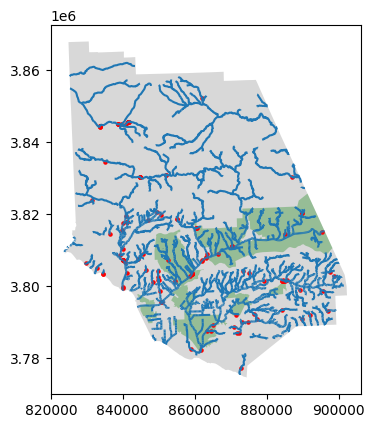

In [ ]:
ax = mask.plot(alpha=0.3,color='gray')
rivers_streams.plot(ax=ax)
greenbelts.plot(ax=ax,color='green',alpha=0.3)
bobcats_near_water.plot(ax=ax,marker='o',color='red',markersize=5)

In [ ]:
bobcats_near_water.shape

(146, 6)

In [ ]:
bobcats.shape

(329, 6)

In [ ]:
bobcats_in_greenbelts = bobcats[bobcats.within(greenbelts.geometry.union_all())]

<Axes: >

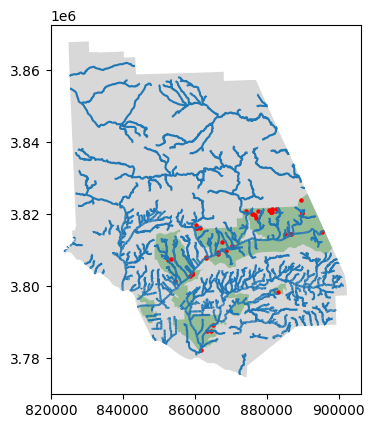

In [ ]:
ax = mask.plot(alpha=0.3,color='gray')
rivers_streams.plot(ax=ax)
greenbelts.plot(ax=ax,color='green',alpha=0.3)
bobcats_in_greenbelts.plot(ax=ax,marker='o',color='red',markersize=5)